In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d



class FatigueData:
    def __init__(self, name, file, threshold, window):
        self.file = file
        self.name = name
        self.threshold = threshold
        self.window = window
        self.data = self.loadData()

     
    def loadData(self):
        data = pd.read_csv(self.file, skiprows=3, header=None)

        def interpolate(df, x, y, likelihood, threshold):
            for i in range(1, len(df)):
                if df.iloc[i, likelihood] < threshold:
                    df.iloc[i, x] = df.iloc[i-1, x]
                    df.iloc[i, y] = df.iloc[i-1, y]

        #interpolate

        for i in range(3,len(data.columns),3):
            likelihood = i + 2  
            x_col = i  
            y_col = i + 1  
            interpolate(data, x_col, y_col, likelihood, self.threshold)

            #moving average
        # for i in range(3, len(data.columns),3):
        #     x = data.columns[i]
        #     y = data.columns[i+1]
        #     data[x] = data[x].rolling(window=self.window, min_periods=1).mean()
        #     data[y] = data[y].rolling(window=self.window, min_periods=1).mean()        

        def calculate_angle(p1,p2, p3):
            #Calculate the angle at p2
            #Calculate the vectors
            v1 = np.array(p1) - np.array(p2)
            v2 = np.array(p3) - np.array(p2)
            #Calculate the angle
            angle = np.arccos(np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            #Convert to degrees
            angle = np.degrees(angle)
            return angle

        angle = []
        for i in range(len(data)):  #save angle for each posture for all frames
            forearm = (data.iloc[i][data.columns[15]], data.iloc[i][data.columns[16]])
            wrist = (data.iloc[i][data.columns[12]], data.iloc[i][data.columns[13]])
            mcp = (data.iloc[i][data.columns[9]], data.iloc[i][data.columns[10]])
            # pip = (data.iloc[i][data.columns[6]], data.iloc[i][data.columns[7]])
            # dip = (data.iloc[i][data.columns[3]], data.iloc[i][data.columns[4]])
            angle.append(calculate_angle(forearm, wrist, mcp))
        smoothed = uniform_filter1d(np.array(angle), size=self.window)
        return smoothed
    
    def plotAll(self,height=130, prominence=10, width=10):

        self.peaks, _ = find_peaks(self.data, height=130, prominence=10, width=10 )  
        self.valleys, _ = find_peaks(-self.data, height=-170, prominence=10, width=10)  
        
        # Plot the results
        plt.figure(figsize=(25, 5))
        plt.plot(self.data)
        plt.plot(self.peaks, self.data[self.peaks], "x", label='Peaks')
        plt.plot(self.valleys, self.data[self.valleys], "o", label='Valleys')
        plt.title(f'{self.name} Fatigue Data')
        plt.xlabel('Frame')
        plt.ylabel('Angle')
        plt.legend()
        plt.show()

    def getAngleChange(self,restIdx):
        angleChanges = []
        print(self.data[self.valleys[-restIdx]])
        for i in range(len(self.peaks)):
            angleChanges.append(self.data[self.peaks[i]] - self.data[self.valleys[-restIdx]])
        self.angleChanges = angleChanges
        # plt.figure(figsize=(10, 6))
        # plt.scatter(np.arange(len(angleChanges)), angleChanges,label='Original Data', color = 'r',)
        # plt.xlabel("Stimulus Number")
        # plt.ylabel("Mean Change in Angle (Percent)")
        # plt.title(f'{self.name} Fatigue Data')
        # plt.legend()
        # plt.show()
    

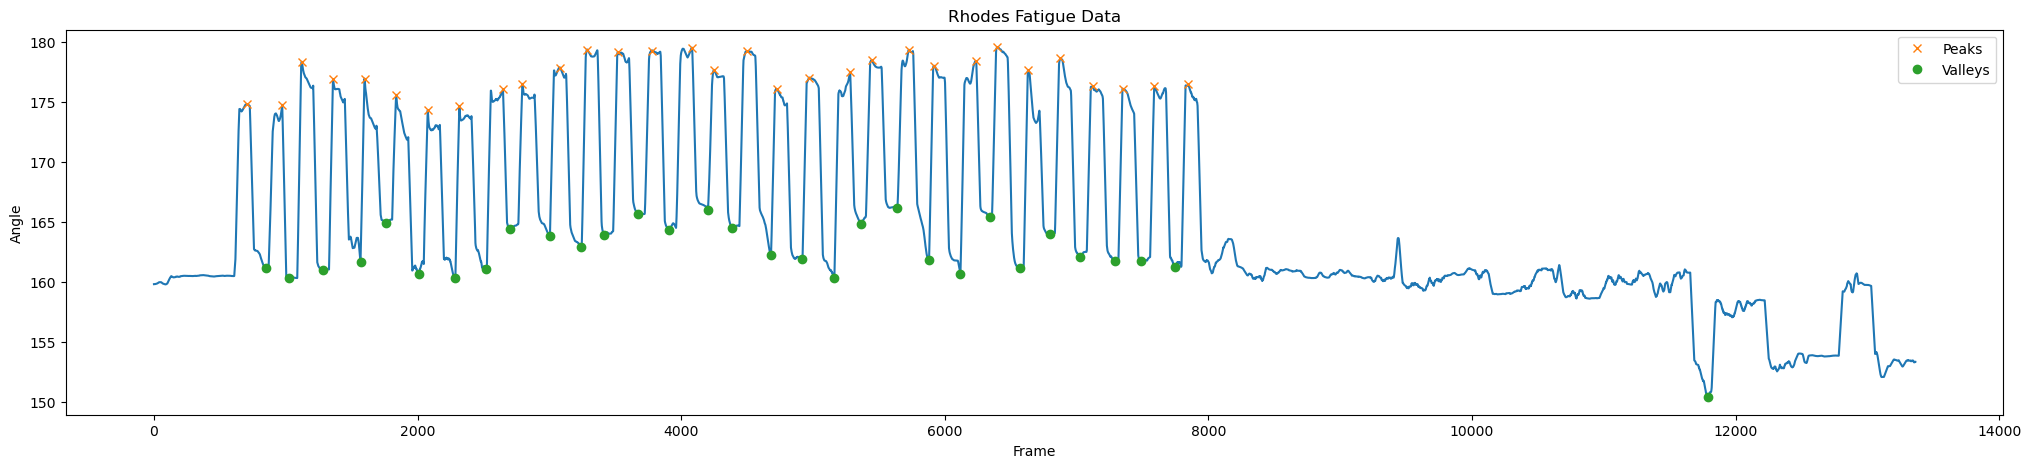

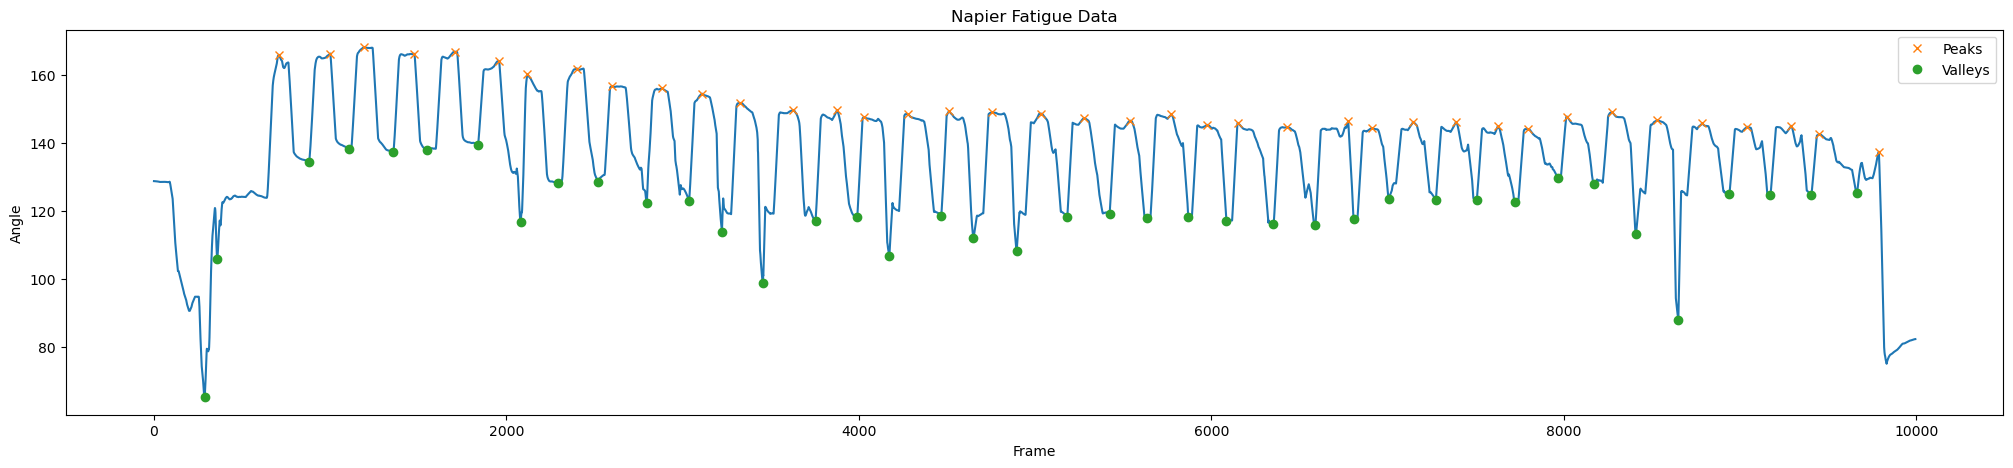

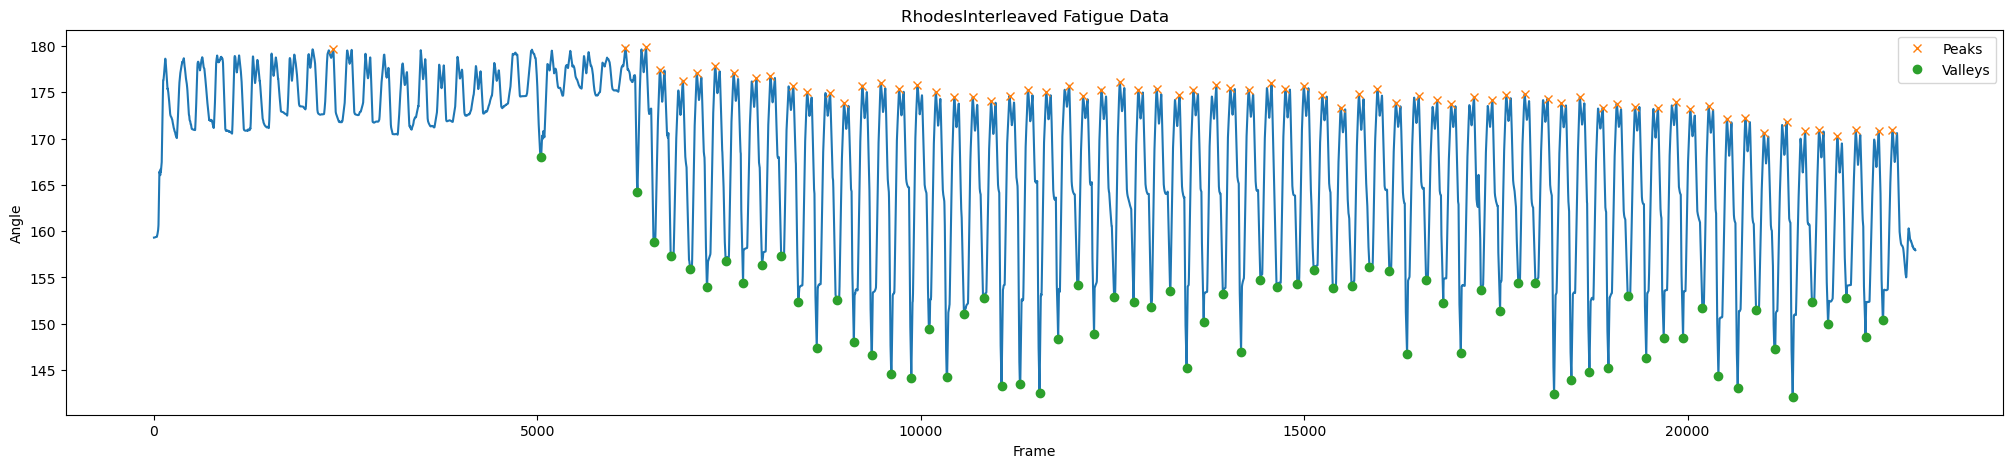

In [47]:
thresh = 0.5
window = 30
rhodes = FatigueData("Rhodes", "/home/jakejoseph/Desktop/Joseph_Code/SLEAPV3/rhodesfatigue.csv", thresh, window)
rhodes.plotAll()
napier = FatigueData("Napier","/home/jakejoseph/Desktop/Joseph_Code/SLEAPV3/napierfatigue.csv", thresh, window)
napier.plotAll()
rhodesinterleaved = FatigueData("RhodesInterleaved","/home/jakejoseph/Desktop/Joseph_Code/SLEAPV3/rhodesinterleavedfatigue.csv", thresh, window)
rhodesinterleaved.plotAll()

161.25047893632686
125.29369212542544
150.41643971171374


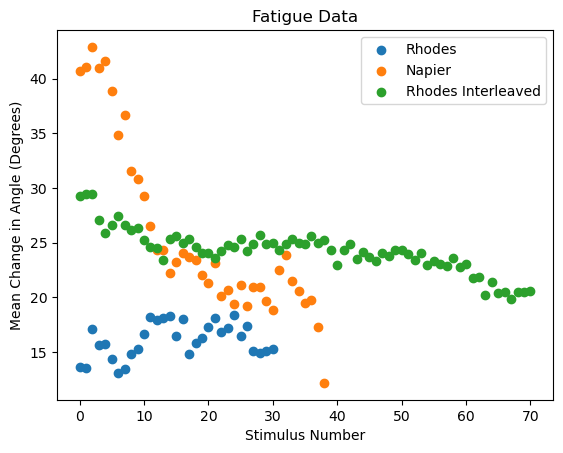

In [52]:
rhodes.getAngleChange(2)
napier.getAngleChange(1)
rhodesinterleaved.getAngleChange(1)
plt.scatter(np.arange(len(rhodes.angleChanges)), rhodes.angleChanges, label='Rhodes')
plt.scatter(np.arange(len(napier.angleChanges)), napier.angleChanges, label='Napier')
plt.scatter(np.arange(len(rhodesinterleaved.angleChanges)), rhodesinterleaved.angleChanges, label='Rhodes Interleaved')
plt.xlabel("Stimulus Number")
plt.ylabel("Mean Change in Angle (Degrees)")
plt.title(f'Fatigue Data')
plt.legend()
